In [1]:
# !pip install fast-bert
# !git clone https://github.com/NVIDIA/apex
# %cd apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
# %cd ..

# Data scraping and collection

### I've collected data from r/India using pushshift's api. Later on to extract the data from the url given I've used PRAW's api as it is way more efficient at retrieving data from url whereas Pushshift's api is retrieving huge amounts of data.

In [ ]:
api = PushshiftAPI()

In [48]:
import datetime as dt

start_epoch=int(dt.datetime(2019, 1).timestamp())

datas = list(list(api.search_submissions(after=start_epoch,
                            subreddit='politics',
                            filter=['url','title', 'subreddit'],
                            limit=30000)))

### After collecting data from r/india, i have split the data into text and labels

### Data has been extracted from November 2019 to present day

### Most comon words from the r/india datasetmmm

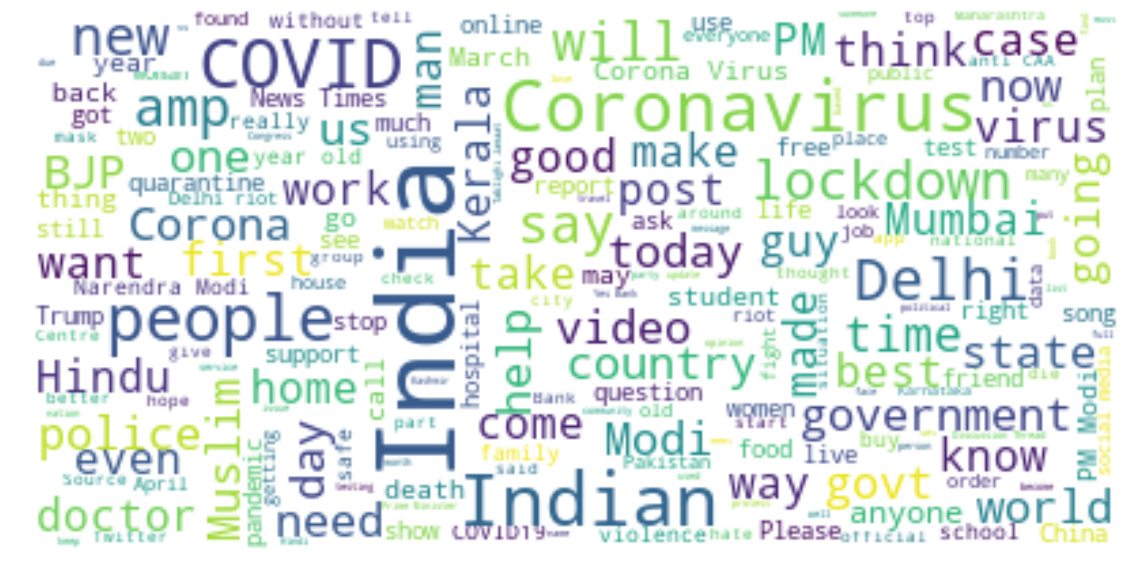

In [28]:
# lower max_font_size
wordcloud = WordCloud(max_font_size=40, background_color="white").generate(s)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Examples of the corresponding labels

In [31]:
data.head(10)

,id,text,label
0,0,The level of insecurity is astounding,Non-Political
1,1,BSNL ADSL Broadband : Thoughts,AskIndia
2,2,Many people don't seem to know this...,Food
3,3,Something like this is what the medical commun...,Coronavirus
4,4,Why does r/india seem to have an anti BJP bias?,Politics
5,5,28 quarantined by Jharkhand police for Tabligh...,Coronavirus
6,6,My Corona song #Lockdown,Coronavirus
7,7,Have Plagues Repeated Exactly Every 100 Years?,Non-Political
8,8,Jamaat members defecate in front of Narela qua...,Coronavirus
9,9,Misbehaving with Dr. Sanjeevani because she is...,Coronavirus


### The number articles present vs label

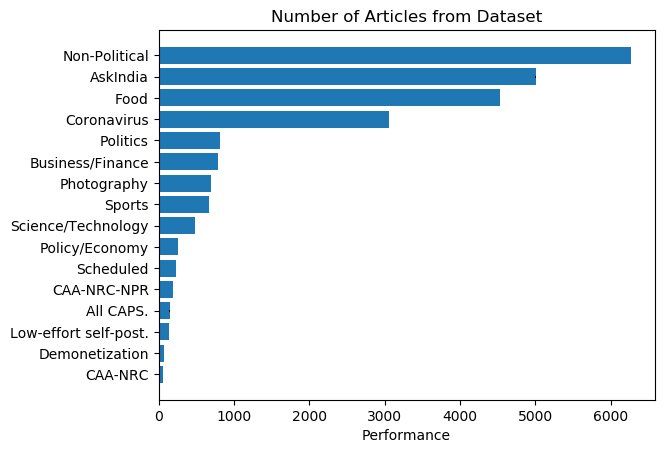

### Due to the lack of articles after CAA/NRC, I have decided to discard the remaining in my training and testing dataset

### Most of the classes such as Science/Technology and Sports etc can fall under the Non-Political category and that solely depends on the kinds of reddit has. I have ignored some classes where the availability of data is extremely less and decided to keep some.

### Due to this, the model performs in a way where some classes despite belonging to other classes fall under 'Non-Political' category as it techinaclly is 'Non-Political'. This can be fixed by acquiring more data.

### These are the remaining flaris present in the dataset

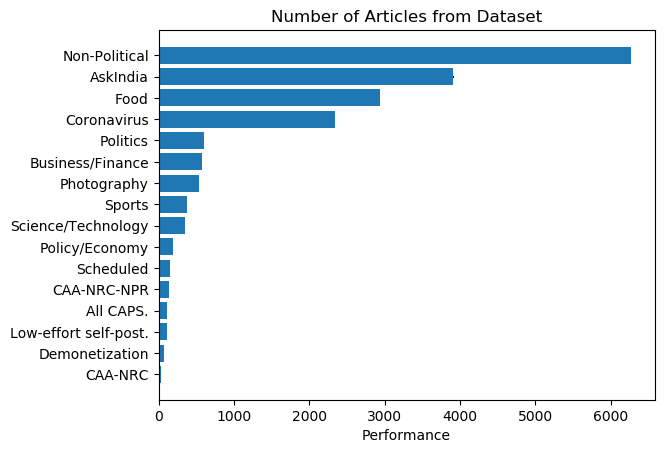

# Using Fast-Bert to train BERT model with Nvidia's Apex. 
## I have used it's 'bert' model to train

In [0]:
from fast_bert.data_cls import BertDataBunch

databunch = BertDataBunch('', '',
                          tokenizer='bert-base-uncased',
                          train_file='train.csv',
                          val_file='test.csv',
                          label_file='labels.csv',
                          text_col='text',
                          label_col='label',
                          batch_size_per_gpu=16,
                          max_seq_length=512,
                          multi_gpu=True,
                          multi_label=False,
                          model_type='bert')

from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
import logging
import torch

logger = logging.getLogger()
device_cuda = torch.device("cuda")
metrics = [{'name': 'accuracy', 'function': accuracy}]

learner = BertLearner.from_pretrained_model(
						databunch,
						pretrained_path='bert-base-uncased',
						metrics=metrics,
						device=device_cuda,
						logger=logger,
						output_dir='',
						finetuned_wgts_path=None,
						warmup_steps=500,
						multi_gpu=True,
						is_fp16=True,
						multi_label=False,
						logging_steps=50)

### The model is as desctibed above, I am using a predefined bert model with accuracy as measurements of metrics.
### Learning rate = 0.000006 and optimizer = lamb (Layer-wise Adaptive Moments optimizer for Batch training) with 6 epochs of training on Google Colab's Nvidia Tesla (with a training time of 7hrs).

In [5]:
learner.fit(epochs=6,
			lr=6e-5,
			validate=True, 	# Evaluate the model after each epoch
			schedule_type="warmup_cosine",
			optimizer_type="lamb")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


(7020, 1.5578393462801252)

In [0]:
learner.save_model()

### The model performs pretty well with the required text. The only issue with the data is that there isn't equal weightage for all the classes. Some classes are subsets are of the other classes such as Sports belongs in Non politics.